In [63]:
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from pandas import DataFrame

import pandas as pd
from pylab import rcParams
import seaborn as sb
import matplotlib.pyplot as plt
from statistics import mean
import statistics
import math
import plotly.graph_objects as go

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def dbscan(df, eps, minPoints):
    df_values = df[['value']]
    
    outliersIndexes = []
    clustersAndValues = {}
    clusterIndex = 0
    
    lastValue = df_values.iloc[0].value
    lastIndexSaved = 0
    
    for index, row in df_values.iterrows():
        currentValue = row.value
        differenceValue = abs(currentValue - lastValue)
     
        if(differenceValue > eps):
            clusterIndex+=1
      
        if clusterIndex not in clustersAndValues:
            clustersAndValues.setdefault(clusterIndex, [])
            clustersAndValues[clusterIndex].append(currentValue)
        else:
            clustersAndValues[clusterIndex].append(currentValue)
        
        if len(clustersAndValues.get(clusterIndex, 0)) <= minPoints:
            outliersIndexes.append(index)
            lastIndexSaved = index
        
        if len(clustersAndValues.get(clusterIndex, 0)) > minPoints and lastIndexSaved in outliersIndexes:
            outliersIndexes.remove(lastIndexSaved)

        lastValue = currentValue

    return clustersAndValues, outliersIndexes

def compute_distances(values):
    distances = []
    
    for index, value in enumerate(values):
        if(index < len(values) - 1):
            distance = abs(value - values[index + 1]) 
            distances.append(distance)
       
    return distances

def compute_dispersion(values, mean):
    sum = 0
    for value in values:
        subtractionResult = value - mean
        squareResult = subtractionResult ** 2
        sum += squareResult
    totalNumbers = 1 if len(values) == 0 else len(values)    
    divideResult = sum / totalNumbers
    return math.sqrt(divideResult)

def split_anomalies_and_non_anomalies(df):
    anomalies = []
    nonAnomalies = []
    
    for index, row in df.iterrows():
        checkForAnomalyResult = check_for_anomaly(index, df)
        if(0 == checkForAnomalyResult):
            nonAnomalies.append(row['value'])
        elif(1 == checkForAnomalyResult):
            anomalies.append(row['value'])              
        else:
            continue
  
    return anomalies, nonAnomalies

def check_for_anomaly(index, df):
    currentRow = df.iloc[index]
    
    if(index >= len(df) - 1):
        if (1 == currentRow['anomaly']):
            return 1
        else: 
            return 0
        
    nextRow = df.iloc[index + 1]
    if(0 == currentRow['anomaly'] and 0 == nextRow['anomaly']):
        return 0
    elif(1 == currentRow['anomaly'] and 1 == nextRow['anomaly']):
        return 2
    else:
        return 1
    
def evaluate_results_for_confusion_matrix(df, outliersPredictedIndexes):
    results = {"truePositive" : 0, "trueNegative" : 0, "falsePositive" : 0, "falseNegative" : 0}
    truePositive = 0
    trueNegative = 0
    falsePositive = 0
    falseNegative = 0
    
    for index, row in df.iterrows():
        anomalyValue = row['anomaly']
        if anomalyValue == 1:
            if index in outliersPredictedIndexes:
                results["truePositive"] += 1
            else:
                results["falseNegative"] += 1
        else:
            if index in outliersPredictedIndexes:
                results["falsePositive"] += 1
            else:
                results["trueNegative"] += 1    
    
    return results    

def compute_accuracy(results):
    truePositive = results["truePositive"]
    trueNegative = results["trueNegative"]
    falsePositive = results["falsePositive"]
    falseNegative = results["falseNegative"]
    
    return (truePositive + trueNegative) 
            / (truePositive + trueNegative + falsePositive + falseNegative)
    
def compute_true_negative_rate(results):
    trueNegative = results["trueNegative"]
    falsePositive = results["falsePositive"]
    
    return trueNegative / (trueNegative + falsePositive)

def show_results_graph(clustersAndValues, outliersIndexes):
    fig = plt.figure()
    ax = fig.add_axes([.4,.4, 4, 4])
    colors = ['red', 'lime', 'purple', 'mediumblue', 
              'gold', 'darkred', 'aqua', 'yellowgreen', 
              'cyan', 'fuchsia', 'darkviolet', 'teal', 
              'lightcoral', 'skyblue', 'royalblue', 'olive's]
    index = 0

    for clusterIndex, clusterValues in clustersAndValues.items():
        for value in clusterValues:
            if index in outliersIndexes:
                plt.scatter(index, value, label='skitscat', color='red', s=400, marker="X")
                label = (index, " - ", value)
                plt.annotate(label, (index, value))
            elif index == 942:
                plt.scatter(index, value, label='skitscat', color='yellow', s=600, marker="X")
                label = ("ANOMALY NOT DETECTED")
                plt.annotate(label, (index, value))
            else:
                color = colors[(clusterIndex + 1) % len(colors)]
                plt.scatter(index, value, label='skitscat', color=color, s=100, marker="o")

            index +=1
        
    ax.set_xlabel('index')
    ax.set_ylabel('values')
    plt.title('DBScan')
    plt.show()

def show_confusion_matrix(results):
    headerColor = 'skyblue'
    rowOddColor = 'lightcyan'
    rowEvenColor = 'lightblue'
    
    fig = go.Figure(data=[go.Table(
      header=dict(
        values=['<b>Total population</b>','<b>Condition positive</b>','<b>Condition negative</b>'],
        line_color='darkslategray',
        fill_color=headerColor,
        align=['left','center'],
        font=dict(color='white', size=12)
      ),
      cells=dict(
        values=[
          ['Predicted condition positive', 'Predicted condition negative'],
          [results["truePositive"], results["falsePositive"]],
          [results["falseNegative"], results["trueNegative"]]],
        line_color='darkslategray',
        fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*5],
        align = ['left', 'center'],
        font = dict(color = 'darkslategray', size = 11)
        ))
    ])
    
    fig.show()

def show_accuracy_and_true_negative_rate(accuracy, trueNegativeRate):
    headerColor = 'skyblue'
    rowOddColor = 'lightcyan'
    rowEvenColor = 'lightblue'
    
    fig = go.Figure(data=[go.Table(
      header=dict(
        values=['<b>Accuracy</b>','<b>True negative rate</b>'],
        line_color='darkslategray',
        fill_color=headerColor,
        align=['left','center'],
        font=dict(color='white', size=12)
      ),
      cells=dict(
        values=[[accuracy], [trueNegativeRate]],
        line_color='darkslategray',
        fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*5],
        align = ['left', 'center'],
        font = dict(color = 'darkslategray', size = 11)
        ))
    ])
    
    fig.show()
    
def search_anomalies(df):
    halfIndex = int((len(df)/2))
    anomalies, nonAnomalies = split_anomalies_and_non_anomalies(df[:halfIndex])

    anomalyDistances = compute_distances(anomalies)
    nonAnomalyDistances = compute_distances(nonAnomalies)
   
    maxAnomalyDistances = max(anomalyDistances) if len(anomalyDistances) > 0 else 1
    mean = statistics.median([maxAnomalyDistances, min(nonAnomalyDistances)])
    
    anomaliesDispersion = compute_dispersion(anomalyDistances, mean)
    nonAnomaliesDispersion = compute_dispersion(nonAnomalyDistances, mean)  

    clustersAndValues, outliersPredictedIndexes = dbscan(df, mean, 1)   
    print("Founded {", len(outliersPredictedIndexes), "} outliers, with indexes: ", outliersPredictedIndexes)

    results = evaluate_results_for_confusion_matrix(df, outliersPredictedIndexes)
    show_confusion_matrix(results)
    
    accuracy = compute_accuracy(results)
    trueNegativeRate = compute_true_negative_rate(results)
    show_accuracy_and_true_negative_rate(accuracy, trueNegativeRate)

    show_results_graph(clustersAndValues, outliersPredictedIndexes)
    
    

    

In [37]:
# ==========================    
# ====== read dframes ======
# ==========================   

Founded { 10 } outliers, with indexes:  [28, 61, 113, 212, 494, 902, 974, 1032, 1058, 1413]


{'truePositive': 10, 'trueNegative': 1669, 'falsePositive': 0, 'falseNegative': 1}


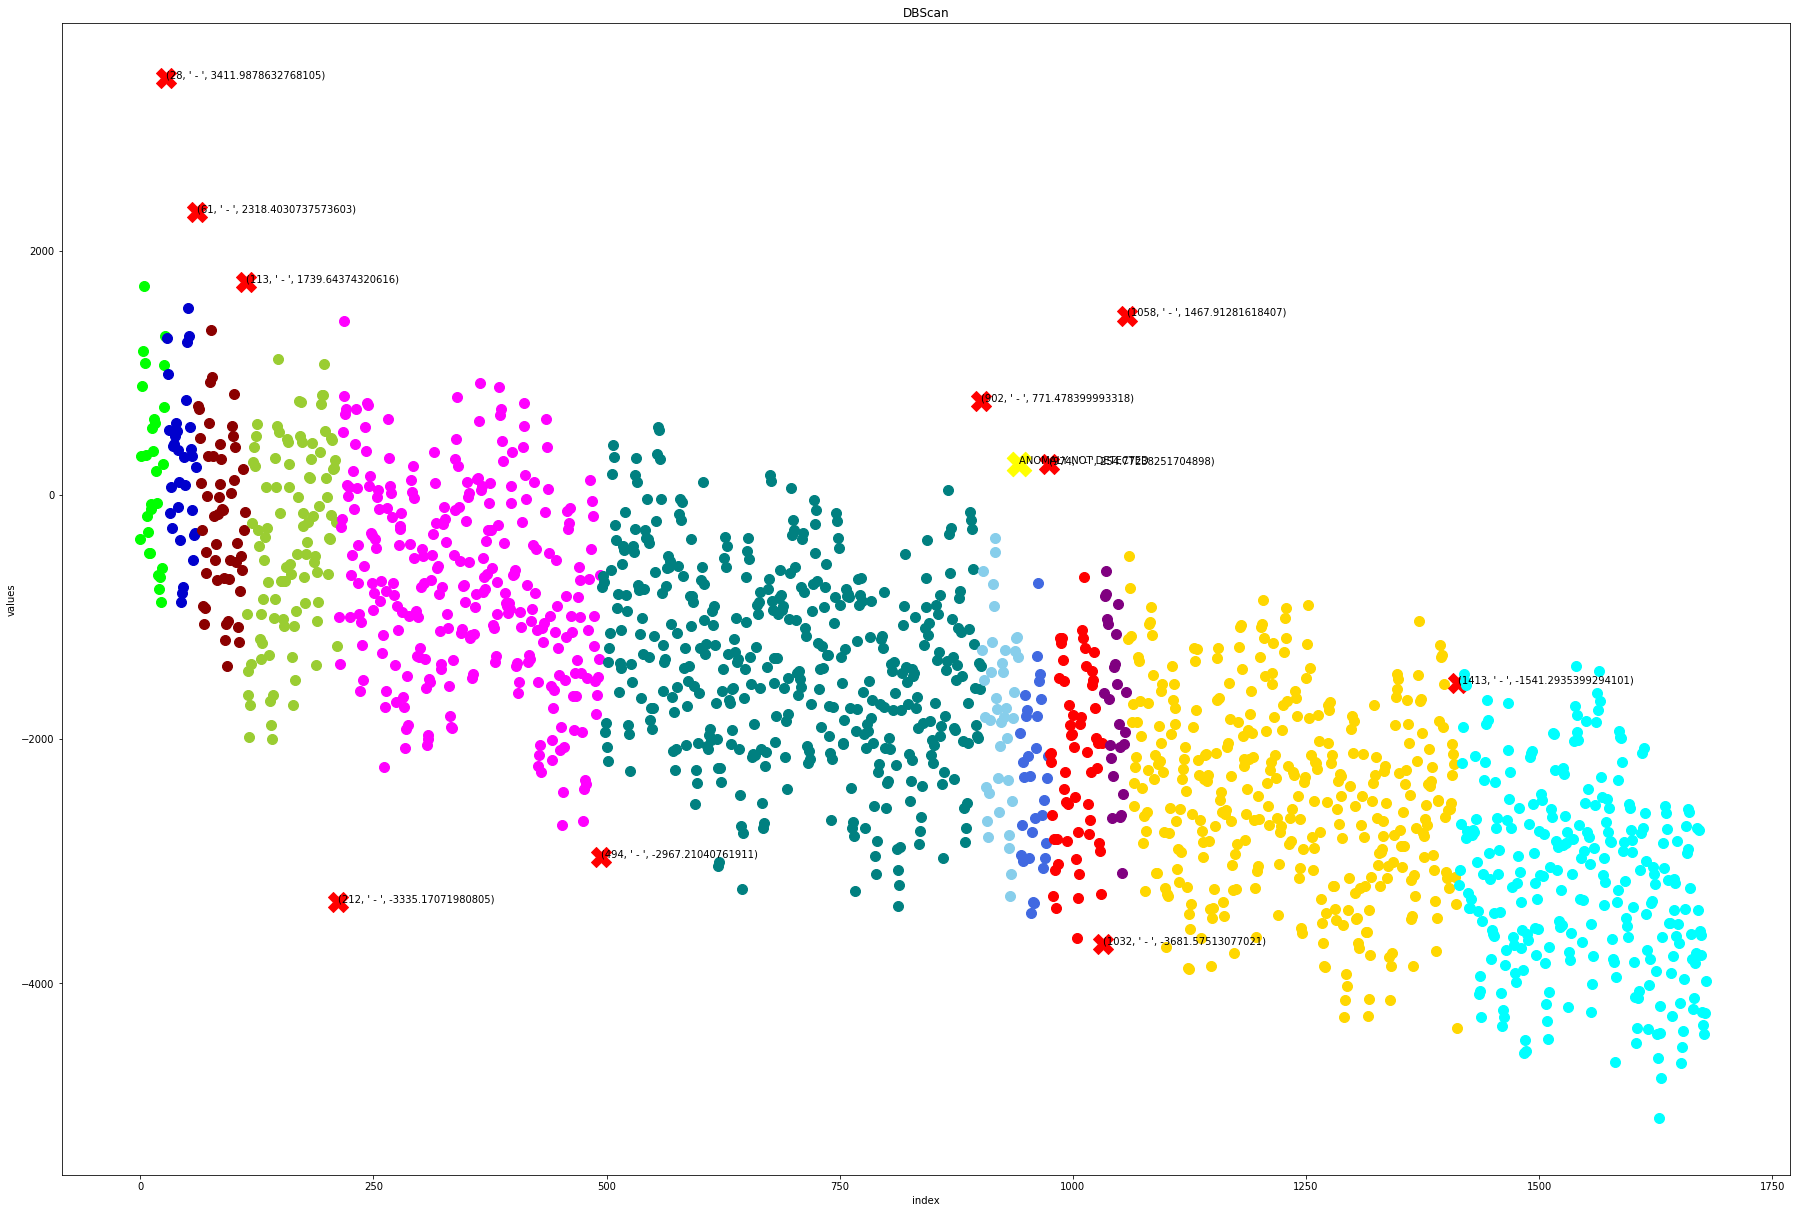

        timestamps        value  anomaly  changepoint  trend       noise  \
28    1.416823e+09  3411.987863        1            0    -58 -152.368844   
61    1.416942e+09  2318.403074        1            0   -124 -334.334218   
113   1.417129e+09  1739.643743        1            0   -228  116.081217   
212   1.417486e+09 -3335.170720        1            0   -426   22.300600   
494   1.418501e+09 -2967.210408        1            0   -990 -135.251008   
902   1.419970e+09   771.478400        1            0  -1806 -384.548559   
942   1.420114e+09   254.958719        1            0  -1886 -273.502398   
974   1.420229e+09   254.772383        1            0  -1950 -131.112546   
1032  1.420438e+09 -3681.575131        1            0  -2066  292.872892   
1058  1.420531e+09  1467.912816        1            0  -2118   94.075095   
1413  1.421809e+09 -1541.293540        1            0  -2828   33.566693   

      seasonality1  seasonality2  seasonality3  
28    7.155102e+02  3.873732e+02    32

In [64]:
df_TS1 = pd.read_csv("data_sets/A3Benchmark-TS1.csv", sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')
search_anomalies(df_TS1)
print(df_TS1[df_TS1['anomaly'] == 1])

#     print("Anomalies distances: ", anomalyDistances)
#     print("mean ", mean)
#     print("not founded one is 942, which has diference lower that training data")
#     print(abs(df.iloc[942]['value'] - df.iloc[943]['value']))
#     print("difference between index 942 and 941 is")
#     print(abs(df.iloc[942]['value'] - df.iloc[941]['value']))
    
#     print("max anomalyDistances", max(anomalyDistances))
#     print("min anomalyDistances", min(anomalyDistances))
        
#     print("min nonAnomalyDistances", min(nonAnomalyDistances))
#     print("max nonAnomalyDistances", max(nonAnomalyDistances))
    
#     print("mean ", mean)



Founded { 16 } outliers, with indexes:  [431, 478, 610, 681, 718, 732, 846, 1019, 1080, 1124, 1171, 1211, 1246, 1411, 1437, 1455]


{'truePositive': 16, 'trueNegative': 1664, 'falsePositive': 0, 'falseNegative': 0}


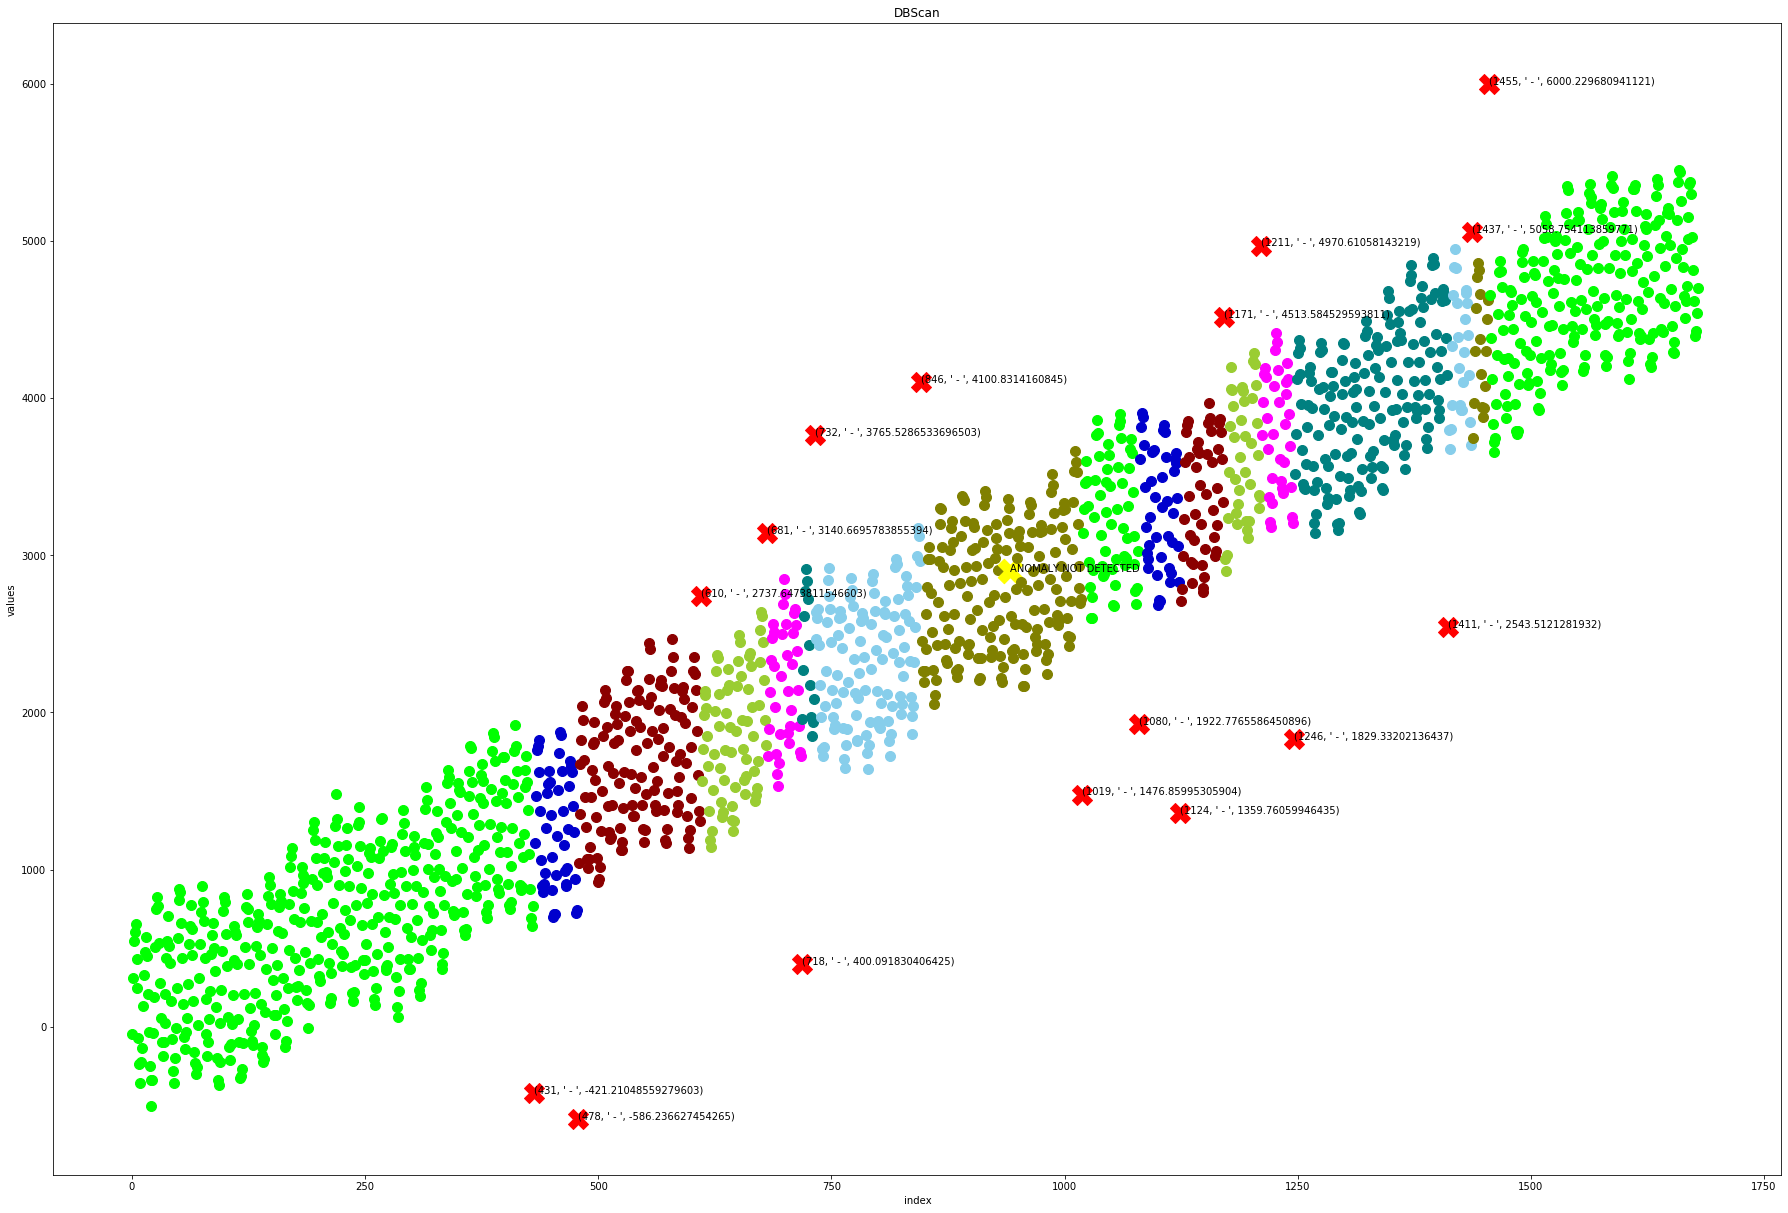

        timestamps        value  anomaly  changepoint  trend      noise  \
431   1.418274e+09  -421.210486        1            0   1296  18.894514   
478   1.418443e+09  -586.236627        1            0   1437 -16.161132   
610   1.418918e+09  2737.647381        1            0   1833 -34.457741   
681   1.419174e+09  3140.669578        1            0   2046  57.946094   
718   1.419307e+09   400.091830        1            0   2157  17.112389   
732   1.419358e+09  3765.528653        1            0   2199  67.133781   
846   1.419768e+09  4100.831416        1            0   2541  -3.947981   
1019  1.420391e+09  1476.859953        1            0   3060 -20.229627   
1080  1.420610e+09  1922.776559        1            0   3243  23.073596   
1124  1.420769e+09  1359.760599        1            0   3375  55.123886   
1171  1.420938e+09  4513.584530        1            0   3516   4.506968   
1211  1.421082e+09  4970.610581        1            0   3636  26.826842   
1246  1.421208e+09  1829.

In [65]:
df_TS2 = pd.read_csv("data_sets/A3Benchmark-TS2.csv", sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')
search_anomalies(df_TS2)
print(df_TS2[df_TS2['anomaly'] == 1])

Founded { 6 } outliers, with indexes:  [253, 433, 860, 1316, 1438, 1547]


{'truePositive': 6, 'trueNegative': 1674, 'falsePositive': 0, 'falseNegative': 0}


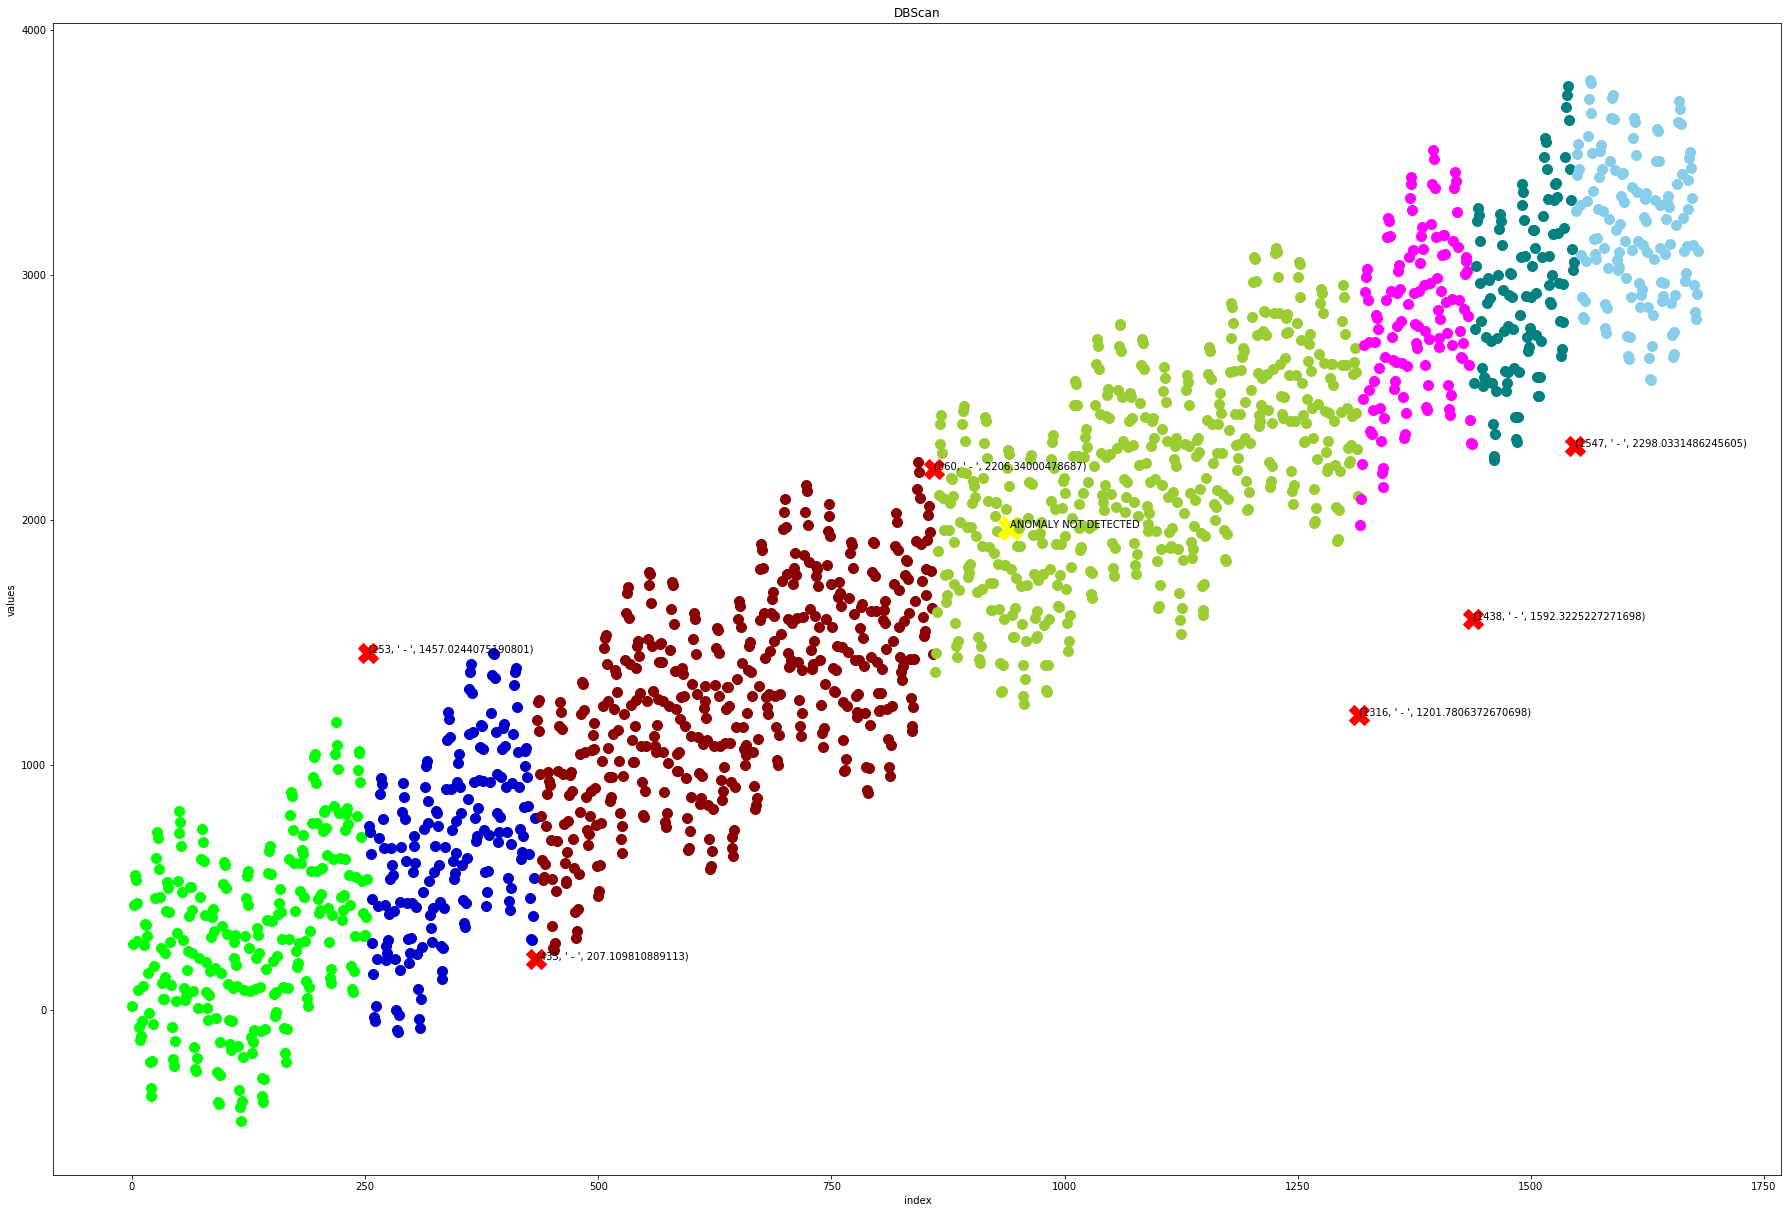

        timestamps        value  anomaly  changepoint  trend      noise  \
253   1.417633e+09  1457.024408        1            0    508  -9.050211   
433   1.418281e+09   207.109811        1            0    868  27.060476   
860   1.419818e+09  2206.340005        1            0   1722  10.493102   
1316  1.421460e+09  1201.780637        1            0   2634  52.578472   
1438  1.421899e+09  1592.322523        1            0   2878  32.335651   
1547  1.422292e+09  2298.033149        1            0   3096 -14.456744   

      seasonality1  seasonality2  seasonality3  
253     182.500000    -51.375580     -7.029545  
433     182.500000     51.375580    -87.846502  
860    -316.099272   -171.906043    127.872475  
1316   -316.099272   -171.906043   -162.812776  
1438   -316.099272    -99.250000    -68.684113  
1547   -182.500000     51.375580    181.594055  


In [67]:
df_TS3 = pd.read_csv("data_sets/A3Benchmark-TS3.csv", sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')
search_anomalies(df_TS3)
print(df_TS3[df_TS3['anomaly'] == 1])

Founded { 1676 } outliers, with indexes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 21

{'truePositive': 6, 'trueNegative': 4, 'falsePositive': 1670, 'falseNegative': 0}


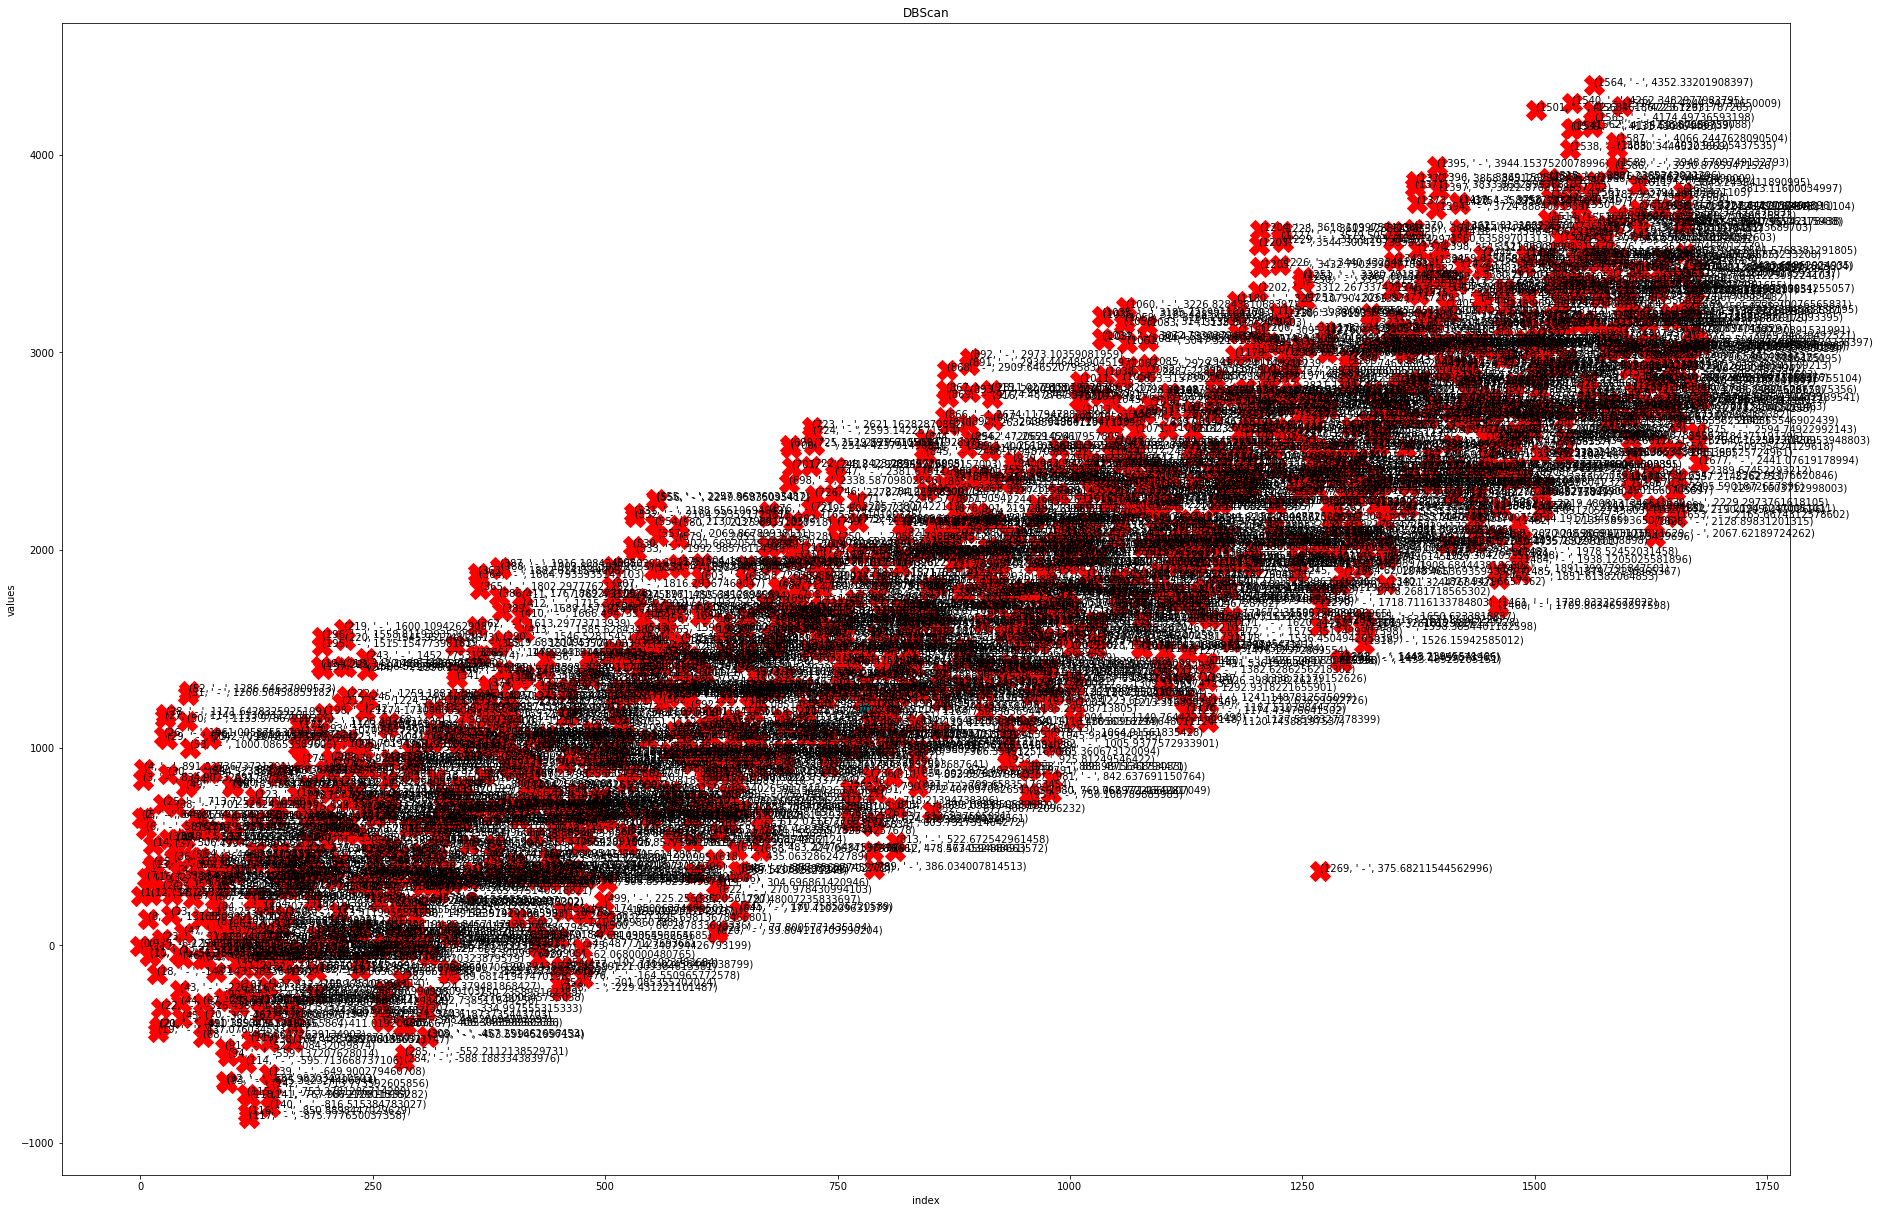

        timestamps        value  anomaly  changepoint  trend      noise  \
852   1.419790e+09   677.306772        1            0   1706  11.358767   
1196  1.421028e+09  3003.377026        1            0   2394 -75.486895   
1269  1.421291e+09   375.682115        1            0   2540 -50.519165   
1406  1.421784e+09  2030.443577        1            0   2814 -61.507128   
1501  1.422126e+09  4223.461867        1            0   3004  36.443187   
1594  1.422461e+09  4244.347317        1            0   3190  21.867412   

      seasonality1  seasonality2  seasonality3  
852   1.883445e-12 -8.339456e-13    166.741521  
1196 -4.154324e+02 -3.678876e+02    261.390383  
1269 -4.797000e+02 -3.003790e+02   -126.926244  
1406  4.154324e+02 -2.124000e+02    281.711834  
1501  2.398500e+02 -1.099463e+02   -153.678505  
1594 -4.154324e+02  2.124000e+02     28.718775  


In [68]:
df_TS4 = pd.read_csv("data_sets/A3Benchmark-TS4.csv", sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')
search_anomalies(df_TS4)
print(df_TS4[df_TS4['anomaly'] == 1])

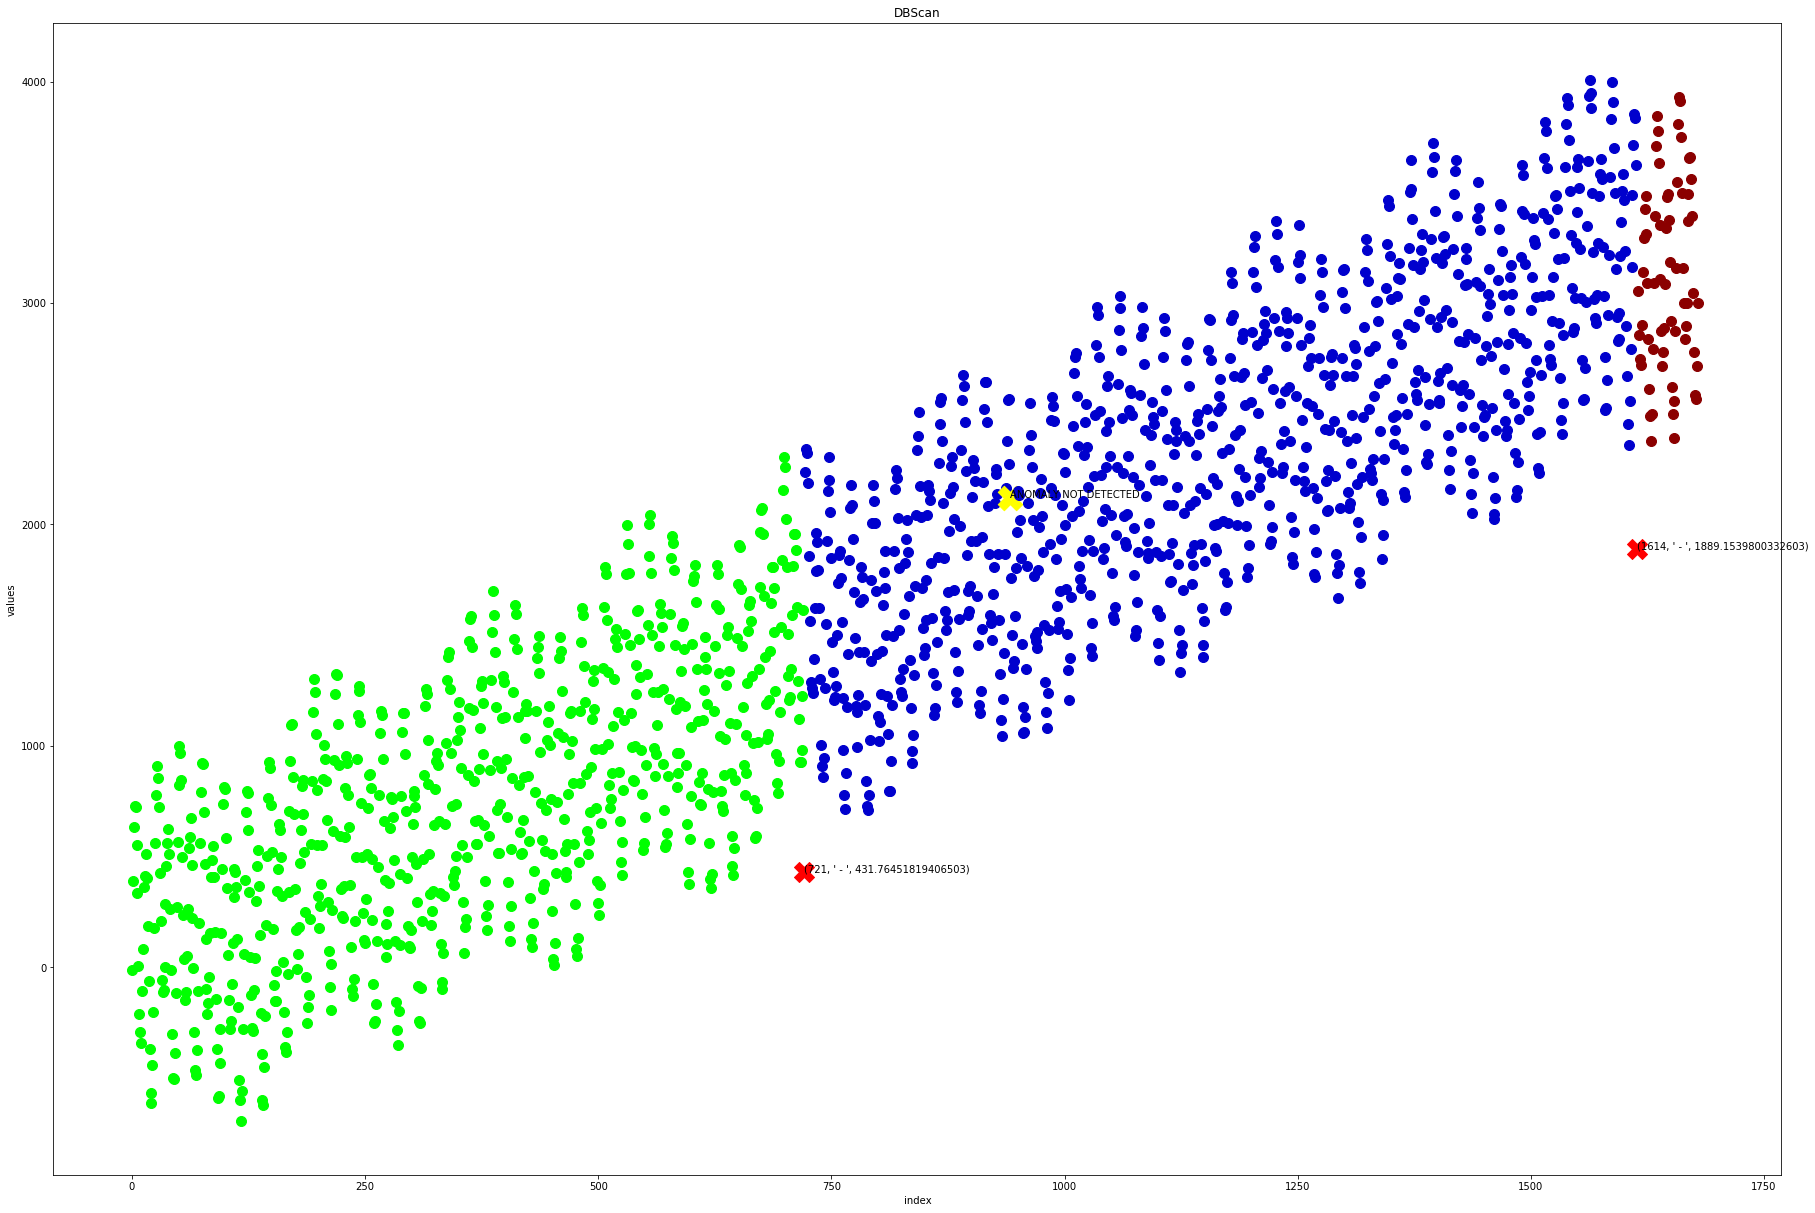

Founded { 2 } outliers, with indexes:  [721, 1614]
        timestamps        value  anomaly  changepoint  trend      noise  \
721   1.419318e+09   431.764518        1            0   1444  -1.163552   
1614  1.422533e+09  1889.153980        1            0   3230  24.112466   

      seasonality1  seasonality2  seasonality3  
721   2.772000e+02     66.464731    162.275539  
1614 -3.097701e-11    256.800000   -104.746287  


In [3]:
df_TS5 = pd.read_csv("data_sets/A3Benchmark-TS5.csv", sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')
search_anomalies(df_TS5)
print(df_TS5[df_TS5['anomaly'] == 1])